<a href="https://colab.research.google.com/github/philastotle/dissertation-pointnet/blob/master/Model1_PointNetFull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1 - PointNet Full Model with Transformation Networks (T-Net)

## Prediction of radiotherapy plan violation from spatial arrangement of target and organ at risk structures using deep learning

_By Phillip Hungerford,  University of New South Wales_

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd drive

/content/drive


In [6]:
cd My Drive

/content/drive/My Drive


In [7]:
cd Dissertation/5_Code/1_code

/content/drive/My Drive/Dissertation/5_Code/1_code


In [8]:
ls

 3D_medical_visualisation_script.py   my_model3140.h5
 best_NNEE.hdf5                       my_model3768.h5
 best_NN.hdf5                         my_model4096.h5
 data_prep.py                         original-voxel-model.ipynb
'EDA&PreProcessing.ipynb'             plot.png
 keras-test.ipynb                     PointNetBasic.ipynb
 model_1024.h5                        __pycache__/
'Model1_PointNetFull (1).ipynb'       tf_util.py
 Model1_PointNetFull.ipynb            trainHistoryDict3768
 my_model10204D.h5                    train.py
 my_model1024xyzl.h5                  voxel-model.ipynb
 my_model_16_16_16.h5                 voxels.ipynb
 my_model20454D.h5                    weights.h5
 my_model31404D.h5


In [0]:
# Install dependencies

# For Google Colab
#!pip install open3d-python

# for reading the ply files 
#from open3d import *
import numpy as np

# To time 
import time

# For reading the labels
import pandas as pd

# Pointnet dependencies
import os
import time
import random
import numpy as np
import tensorflow as tf
from numpy.random import seed
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from keras.layers import Dense, MaxPooling1D, Convolution1D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# fix random seed for reproducibility
seeds=42
random.seed(seeds)
seed(seeds)
set_random_seed(seeds)

In [77]:
# Load data
desired_points = 1024
#X = downsample_dataset(data_points, desired_points)
#np.save('../2_pipeline/prostate-no-nodes-'+ str(desired_points) +'.npy', X)
X = np.load('../2_pipeline/prostate-no-nodes-1024.npy')
#X = np.load('../2_pipeline/no-body-4096.npy')
y = np.load('../2_pipeline/labels.npy')

#split data into 1: train+validation set and 2: test set 
X_train_val, X_test, y_train_val, y_test = \
train_test_split(X, y, random_state=0, test_size=0.2)

# split train+validation set into 1a) training and 1b) validation sets
X_train, X_val, y_train, y_val = \
train_test_split(X_train_val, y_train_val, random_state=1, test_size=0.2)

# Training set
train_points_r = X_train
train_labels_r = y_train


# Test set
test_points_r = X_test
test_labels_r = y_test

# label to categorical
from keras.utils import to_categorical
#y_test = to_categorical(y_test)
#y_train = to_categorical(y_train)
# Let's examine the data. 

print("Training shape: ", train_points_r.shape)
print("Test shape: \t", test_points_r.shape)

Training shape:  (182, 1024, 3)
Test shape: 	 (58, 1024, 3)


In [0]:
# hyperparameter
# number of points in each sample
num_points = desired_points

# number of categories
k = 2

# define optimizer
opt = optimizers.Adam(lr=0.001, decay=0.7)

max_epochs=250
batch_size=32
dropout_rate = 0.7

# Class weights
class_weight = {0: 0.2, 1: 0.8}

In [80]:
### POINTNET ARCHITECTURE

input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu', input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# For affine transformation need to matrix multiply


def mat_mul(A, B):
    return tf.matmul(A, B)


# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)


# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)


# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)


# point_net_cls
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=dropout_rate)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=dropout_rate)(c)
c = Dense(1, activation='sigmoid')(c)
prediction = Flatten()(c)


# print the model summary
model = Model(inputs=input_points, outputs=prediction)
print(model.summary())


# compile classification model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Rotate and jitter points
def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1024, 3)           0         
_________________________________________________________________
lambda_23 (Lambda)           (None, 1024, 3)           0         
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 1024, 64)          256       
_________________________________________________________________
batch_normalization_193 (Bat (None, 1024, 64)          256       
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 1024, 64)          4160      
_________________________________________________________________
batch_normalization_194 (Bat (None, 1024, 64)          256       
_________________________________________________________________
lambda_24 (Lambda)           (None, 1024, 64)          0         
__________

In [81]:
# Fit model on training data
for i in range(1,max_epochs+1):
    # model.fit(train_points_r, Y_train, batch_size=32, epochs=1, shuffle=True, verbose=1)
    # rotate and jitter the points
    train_points_rotate = rotate_point_cloud(train_points_r)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=1,\
                    shuffle=True, verbose=1, validation_data=(X_val, y_val),\
                    class_weight=class_weight)
    s = "Current epoch is:" + str(i)
    print(s)
    if i % 5 == 0:
        score = model.evaluate(test_points_r, y_test, verbose=1)
        print('Test loss: ', score[0])
        print('Test accuracy: ', score[1])


# ## 10. Evaluate the Model
# score the model
score = model.evaluate(test_points_r, y_test, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Train on 182 samples, validate on 46 samples
Epoch 1/1
182/182 [==============================] - 12s 66ms/step - loss: 0.4621 - acc: 0.5659 - val_loss: 1.8577 - val_acc: 0.6739
Current epoch is:1
Train on 182 samples, validate on 46 samples
Epoch 1/1
182/182 [==============================] - 1s 6ms/step - loss: 0.4472 - acc: 0.5495 - val_loss: 3.2776 - val_acc: 0.6739
Current epoch is:2
Train on 182 samples, validate on 46 samples
Epoch 1/1
182/182 [==============================] - 1s 6ms/step - loss: 0.4474 - acc: 0.4945 - val_loss: 3.7113 - val_acc: 0.6739
Current epoch is:3
Train on 182 samples, validate on 46 samples
Epoch 1/1
182/182 [==============================] - 1s 6ms/step - loss: 0.3955 - acc: 0.6099 - val_loss: 3.7045 - val_acc: 0.6739
Current epoch is:4
Train on 182 samples, validate on 46 samples
Epoch 1/1
182/182 [==============================] - 1s 6ms/step - loss: 0.3440 - acc: 0.5989 - val_loss: 3.9929 - val_acc: 0.6739
Current epoch is:5
58/58 [================


###################### Model Performance ############################

Train: 0.973, Test: 0.690

#####################################################################

Our test confusion matrix yields: 
[[31  5]
 [13  9]]

#####################################################################

Classfication Report for test:
               precision    recall  f1-score   support

         0.0       0.70      0.86      0.78        36
         1.0       0.64      0.41      0.50        22

   micro avg       0.69      0.69      0.69        58
   macro avg       0.67      0.64      0.64        58
weighted avg       0.68      0.69      0.67        58


#####################################################################

Our testing AUC for ann is:  0.6351010101010102


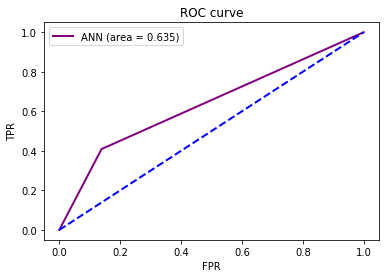


#####################################################################


In [82]:
################################################################################
# Classification Report

# make predictions on the test set
y_pred = model.predict(X_test)

################################################################################
from sklearn.metrics import accuracy_score, confusion_matrix
print("\n###################### Model Performance ############################")
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))
################################################################################
print("\n#####################################################################")
# Create the confusion matrix
ann_cm = confusion_matrix(y_true = y_test, y_pred = y_pred.round())
print("\nOur test confusion matrix yields: ")
print(ann_cm)
print("\n#####################################################################")

#Classification report
ann_report = classification_report(y_test, y_pred.round())
print("\nClassfication Report for test:\n", ann_report)
print("\n#####################################################################")

#Calculate AUC score
from sklearn.metrics import roc_auc_score
ann_auc = roc_auc_score(y_test, y_pred.round())
print("\nOur testing AUC for ann is: ", ann_auc)

from sklearn.metrics import roc_curve
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred.round())

# Plot AUC 
plt.figure()
plt.plot(fpr_ann, tpr_ann, color='purple', lw=2, label='ANN (area = {:.3f})'.format(ann_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("\n#####################################################################")